In [1]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
skip_training = True  # Flag to skip training cell if interested only in plotting saved learning curves
scenario_type = "indoor" # indoor, outdoor, indoor+outdoor
dst_path = "./dataset" # dataset dir previously downloaded
log_dir = "logs" # learning curve dir
ckpt_dir = "checkpoints" # best saved model

In [3]:
# Model translated from CSINet original repository

img_height = 32
img_width = 32
img_channels = 2
img_total = img_height * img_width * img_channels

class ResidualBlockDecoded(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 2, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(2)
        self.act   = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        shortcut = x
        y = self.act(self.bn1(self.conv1(x)))
        y = self.act(self.bn2(self.conv2(y)))
        y = self.bn3(self.conv3(y))
        y = self.act(shortcut + y)
        return y

class CsiNet(nn.Module):
    def __init__(self, encoded_dim=512, residual_num=2):
        super().__init__()
        self.encoded_dim = encoded_dim
        self.residual_num = residual_num

        # first conv
        self.conv_in = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.bn_in   = nn.BatchNorm2d(2)
        self.act     = nn.LeakyReLU(inplace=True)

        # encoder dense
        self.fc_enc  = nn.Linear(img_total, encoded_dim)

        # decoder dense
        self.fc_dec  = nn.Linear(encoded_dim, img_total)

        # residual blocks
        self.res_blocks = nn.ModuleList([ResidualBlockDecoded() for _ in range(residual_num)])

        # final conv + sigmoid
        self.conv_out = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.sigmoid  = nn.Sigmoid()

    def forward(self, x):
        # x: (B, 2, 32, 32)
        x = self.act(self.bn_in(self.conv_in(x)))
        # flatten
        B = x.size(0)
        x = x.view(B, -1)              # (B, img_total)
        encoded = self.fc_enc(x)       # (B, encoded_dim)

        x = self.fc_dec(encoded)       # (B, img_total)
        x = x.view(B, img_channels, img_height, img_width)
        for block in self.res_blocks:
            x = block(x)

        x = self.sigmoid(self.conv_out(x))  # (B, 2, 32, 32), in [0,1]
        return x, encoded  # return encoded if you want bottleneck too


In [4]:
dataset_list = os.listdir(dst_path)
dataset_list

['DATA_HtestFin_all.mat',
 'DATA_HtestFout_all.mat',
 'DATA_Htestin.mat',
 'DATA_Htestout.mat',
 'DATA_Htrainin.mat',
 'DATA_Htrainout.mat',
 'DATA_Hvalin.mat',
 'DATA_Hvalout.mat']

In [5]:
# Load datasets according to scenario_type
if scenario_type == "indoor": 
    
    H_train   = sio.loadmat(os.path.join(dst_path, "DATA_Htrainin.mat"))["HT"]
    H_val     = sio.loadmat(os.path.join(dst_path, "DATA_Hvalin.mat"))["HT"]
    H_test    = sio.loadmat(os.path.join(dst_path, "DATA_Htestin.mat"))["HT"]
    
elif scenario_type == "outdoor":
    
    H_train   = sio.loadmat(os.path.join(dst_path, "DATA_Htrainout.mat"))["HT"]
    H_val    = sio.loadmat(os.path.join(dst_path, "DATA_Hvalout.mat"))["HT"]
    H_test    = sio.loadmat(os.path.join(dst_path, "DATA_Htestout.mat"))["HT"]
    
elif scenario_type == "indoor+outdoor":
    
    H_train_in   = sio.loadmat(os.path.join(dst_path, "DATA_Htrainin.mat"))["HT"]
    H_val_in     = sio.loadmat(os.path.join(dst_path, "DATA_Hvalin.mat"))["HT"]
    H_test_in    = sio.loadmat(os.path.join(dst_path, "DATA_Htestin.mat"))["HT"]
    
    H_train_out  = sio.loadmat(os.path.join(dst_path, "DATA_Htrainout.mat"))["HT"]
    H_val_out    = sio.loadmat(os.path.join(dst_path, "DATA_Hvalout.mat"))["HT"]
    H_test_out   = sio.loadmat(os.path.join(dst_path, "DATA_Htestout.mat"))["HT"]

    # Concatenation of both scenarios
    H_train = np.concatenate([H_train_in, H_train_out], axis=0)
    H_val   = np.concatenate([H_val_in,   H_val_out],   axis=0)
    H_test  = np.concatenate([H_test_in,  H_test_out],  axis=0)

IMG_C, IMG_H, IMG_W = 2, 32, 32   # (channels, delay, angle/antenna)

H_train = H_train.reshape(-1, IMG_C, IMG_H, IMG_W)
H_val = H_val.reshape(-1, IMG_C, IMG_H, IMG_W)
H_test = H_test.reshape(-1, IMG_C, IMG_H, IMG_W)

print("Train shape :", H_train.shape)
print("Val shape   :", H_val.shape)
print("Test shape  :", H_test.shape)

Train shape : (100000, 2, 32, 32)
Val shape   : (30000, 2, 32, 32)
Test shape  : (20000, 2, 32, 32)


In [6]:
if not skip_training:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # x_train, x_val, x_test should be numpy arrays (N, 2, 32, 32) in [0,1]
    x_train_t = torch.from_numpy(H_train).float().to(device)
    x_val_t   = torch.from_numpy(H_val).float().to(device)
    x_test_t  = torch.from_numpy(H_test).float().to(device)
    
    train_loader = DataLoader(TensorDataset(x_train_t, x_train_t),
                              batch_size=200, shuffle=True)
    val_loader   = DataLoader(TensorDataset(x_val_t, x_val_t),
                              batch_size=200, shuffle=False)
    
    model = CsiNet(encoded_dim=512, residual_num=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    epochs   = 1000
    patience = 10
    
    # checkpoint dir
    os.makedirs(ckpt_dir, exist_ok=True)
    best_ckpt_path = os.path.join(ckpt_dir, "csinet_best" + "_" + scenario_type + ".pt")
    
    best_val_loss = float("inf")
    patience_ctr  = 0
    
    train_losses = []
    val_losses   = []
    
    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            y_hat, _ = model(xb)
            loss = criterion(y_hat, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)
    
        # ---- VALIDATION ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                y_hat, _ = model(xb)
                loss = criterion(y_hat, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
        print(f"Epoch {epoch}: train {train_loss:.4e}, val {val_loss:.4e}")
    
        # ---- EARLY STOPPING + SAVE BEST MODEL ----
        if val_loss < best_val_loss - 1e-6:  # improved
            best_val_loss = val_loss
            patience_ctr  = 0
    
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss
            }, best_ckpt_path)
    
            print(f"  --> New best model saved to {best_ckpt_path} "
                  f"(val_loss={val_loss:.4e})")
        else:
            patience_ctr += 1
            print(f"  No improvement for {patience_ctr}/{patience} epochs")
    
            if patience_ctr >= patience:
                print("Early stopping triggered.")
                break
    
    print(f"Training finished. Best val_loss={best_val_loss:.4e}")
    
    os.makedirs(log_dir, exist_ok=True)
    np.save(os.path.join(log_dir, "train_losses" + "_" + scenario_type + ".npy"), np.array(train_losses))
    np.save(os.path.join(log_dir, "val_losses" + "_" + scenario_type + ".npy"),   np.array(val_losses))

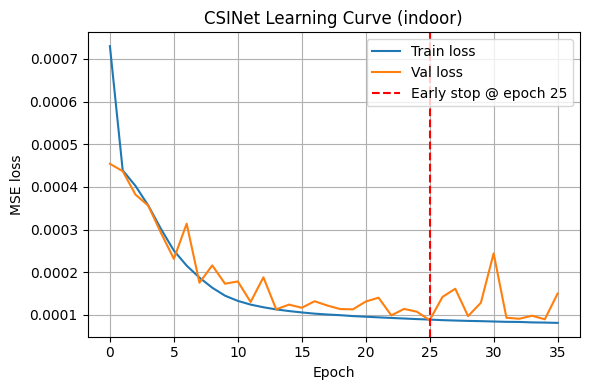

In [7]:
# Load losses
train_losses = np.load(os.path.join(log_dir, "train_losses" + "_" + scenario_type + ".npy"))
val_losses   = np.load(os.path.join(log_dir, "val_losses"   + "_" + scenario_type + ".npy"))

# Load early stopping epoch from checkpoint
checkpoint = torch.load(os.path.join(ckpt_dir, "csinet_best" + "_" + scenario_type + ".pt"), map_location='cpu')
best_epoch = checkpoint['epoch']   # the epoch where best val loss was saved

# Plot learning curves
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")

# Vertical line for early stopping
plt.axvline(best_epoch, color='red', linestyle='--', linewidth=1.5,
            label=f"Early stop @ epoch {best_epoch}")

plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("CSINet Learning Curve (" + scenario_type + ")")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(os.path.join(log_dir, "learning_curve_" + scenario_type + ".png"))
plt.show()